In [1]:
import numpy as np
import pandas as pd 
from scipy.spatial.distance import cosine
import matplotlib.pylab as plt

from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression

def scaler_(vec, unto):
    return vec.dot(unto)/unto.dot(unto)

def project_(vec, unto):
    return scaler_(vec, unto) * unto

def orthogonal_(arr, away):
    return arr - project_(arr, away)

In [2]:
from sklego.preprocessing import OrthogonalTransformer

In [3]:
def simple_mod():
    return Pipeline([("scale", StandardScaler()), ("mod", LinearRegression())])

def bootstrapper(X, var, n=250, k=25):
    selector = df[var] > np.quantile(df[var], 0.5)
    mod = simple_mod().fit(X, y)
    mod_df = pd.DataFrame(X)
    res = []
    for i in range(n):
        s1 = mod.predict(mod_df[selector].sample(k))
        s2 = mod.predict(mod_df[~selector].sample(k))
        res.append(s1.mean() - s2.mean())
    return res, np.mean(res)

def bootstrap_plot(X, X_fair, sens_var, n=2000, k=50):
    mod_fair = simple_mod().fit(X_fair, y)
    mod_unfair = simple_mod().fit(X, y)
    
    samples, avg1 = bootstrapper(X, var=sens_var, n=n, k=k)
    height, bins, _ = plt.hist(samples, density=True, alpha=0.6, bins=30)
    plt.vlines(avg1, 0, height.max());
    
    samples, avg2 = bootstrapper(X_fair, var=sens_var, n=n, k=k)
    height, bins, _ = plt.hist(samples, density=True, alpha=0.6, bins=30)
    plt.vlines(avg2, 0, height.max())
    print(f"difference = {avg2 - avg1} -> {(avg2 - avg1)/np.abs(avg1)}");

In [107]:
(v2 * v1).sum()

4.656612873077393e-10

In [108]:
var = "lstat"

X, y = load_boston(return_X_y=True)
df = pd.DataFrame(X, columns=['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat'])

v1 = df['lstat']
v2 = df['b'] - project_(df['b'], v1)

X_fair = pd.DataFrame([df[c] - project_(df[c], v1) - project_(df[c], v2) for c in df.columns]).T.values
X_fair = pd.DataFrame(X_fair, columns=df.columns).drop(columns=['b', 'lstat'])

X_drop = df.drop(columns=var).values
df.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


In [109]:
X_fair.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio
0,1.324292,-1.341702,-3.503309,-0.079133,0.108253,0.529927,19.304354,-0.423321,-2.513147,32.027570,-0.630086
1,-0.977140,-15.820786,-1.593818,-0.077157,-0.036831,0.076198,19.939300,0.666608,-4.508858,-100.641522,0.079753
2,1.833598,-19.904196,1.932269,-0.078748,0.060101,1.266684,18.498212,0.454070,-0.829780,-2.265959,2.420103


In [110]:
base_mod = simple_mod().fit(X, y)
drop_mod = simple_mod().fit(X_drop, y)
fair_mod = simple_mod().fit(X_fair, y)

base_pred = base_mod.predict(X)
drop_pred = drop_mod.predict(X_drop)
fair_pred = fair_mod.predict(X_fair)

selector = df[var] > np.quantile(df[var], 0.5)

In [126]:
pd.DataFrame([base_mod.steps[1][1].coef_, drop_mod.steps[1][1].coef_, fair_mod.steps[1][1].coef_], columns=df.columns)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,-0.928146,1.081569,0.140900,0.681740,-2.056718,2.674230,0.019466,-3.104044,2.662218,-2.076782,-2.060607,0.849268,-3.743627
1,-1.374364,0.905733,-0.191364,0.816182,-2.371357,4.297922,-1.291657,-3.270958,2.449323,-1.976397,-2.193566,1.242283,NaN
2,-0.763568,1.028051,0.061393,0.697504,-1.605464,6.846774,-0.057920,-2.537602,1.935058,-1.779825,-2.793069,NaN,NaN


In [112]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y, base_pred), mean_squared_error(y, drop_pred), mean_squared_error(y, fair_pred)

(21.894831181729202, 26.659334520325558, 65.61848671196229)

In [113]:
def bootstrap_means(preds, selector, n=2500, k=25):
    grp1 = np.random.choice(preds[selector], (n, k)).mean(axis=1)
    grp2 = np.random.choice(preds[~selector], (n, k)).mean(axis=1)
    return grp1 - grp2

# No Difference in Same Model

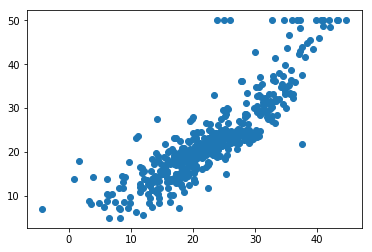

In [114]:
plt.scatter(base_pred, y);

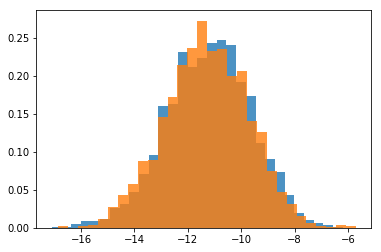

In [115]:
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8);
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8);

# Difference by Dropping Column

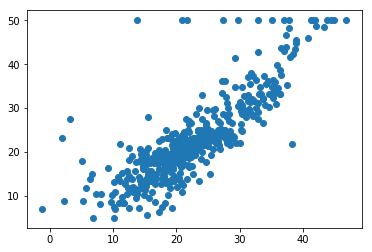

In [116]:
plt.scatter(drop_pred, y);

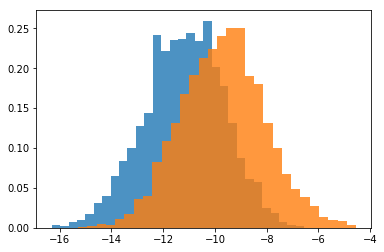

In [117]:
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8);
plt.hist(bootstrap_means(drop_pred, selector), bins=30, density=True, alpha=0.8);

# Difference by Filtering Column

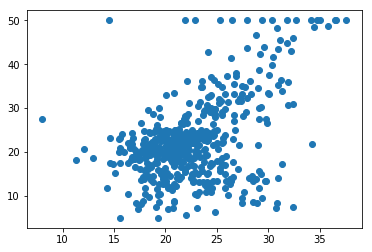

In [118]:
plt.scatter(fair_pred, y);

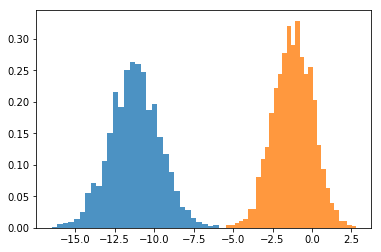

In [119]:
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8);
plt.hist(bootstrap_means(fair_pred, selector), bins=30, density=True, alpha=0.8);

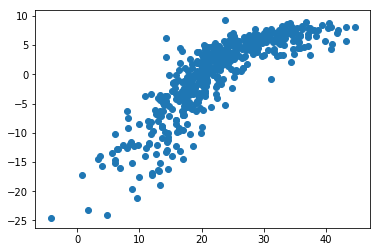

In [134]:
plt.scatter(base_pred, base_pred - fair_pred)